# 🚀 Artificial Intelligence - 2025 | Week 12
*Unlock the Future with Intelligent Machines* 🤖✨

- **Author:** Teerapong Panboonyuen (also known as Kao Panboonyuen)
- **GitHub:** [kaopanboonyuen/SC310005_ArtificialIntelligence_2025s1](https://github.com/kaopanboonyuen/SC310005_ArtificialIntelligence_2025s1)

# 🎯 Reinforcement Learning Lab — Online Retail (Colab-ready)


This Colab-ready Python notebook turns the `RL_Online_Retail.csv` transaction dataset into **a family of teaching environments** and trains/evaluates many RL algorithms so students can compare ideas and metrics.


Features:
- ✅ Load dataset from GitHub raw URL
- ✅ Build a _discrete recommendation environment_ (Tabular) from top-N items
- ✅ Build a _continuous pricing environment_ (synthetic but data-informed) for TD3/SAC
- ✅ Implement & demo: **Q-Learning, DQN, REINFORCE, Actor-Critic, Dyna-Q** (from-scratch / educational)
- ✅ Use **stable-baselines3** (if available) to run **PPO, A2C, DQN, TD3, SAC** quickly for comparison
- ✅ Evaluation metrics: average return, conversion rate, std, training time, sample-efficiency
- ✅ Save / load models, run inference and summarize results in a comparison table


Notes for instructor: run in Colab. Cells are marked for clarity. Each section contains markdown explanation and code.

# Setup: pip installs (run this cell in Colab)

In [ ]:
!pip install stable-baselines3[extra] -q
!pip install gymnasium -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 2.7 MB/s eta 0:00:00


# 1️⃣ Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env

import warnings
warnings.filterwarnings("ignore")

# 2️⃣ Load Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/kaopanboonyuen/panboonyuen_dataset/main/public_dataset/RL_Online_Retail.csv'
df = pd.read_csv(url, parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


3️⃣ Exploratory Data Analysis (EDA) & Preprocessing 📊

In [ ]:
# Understand the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
df.describe()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


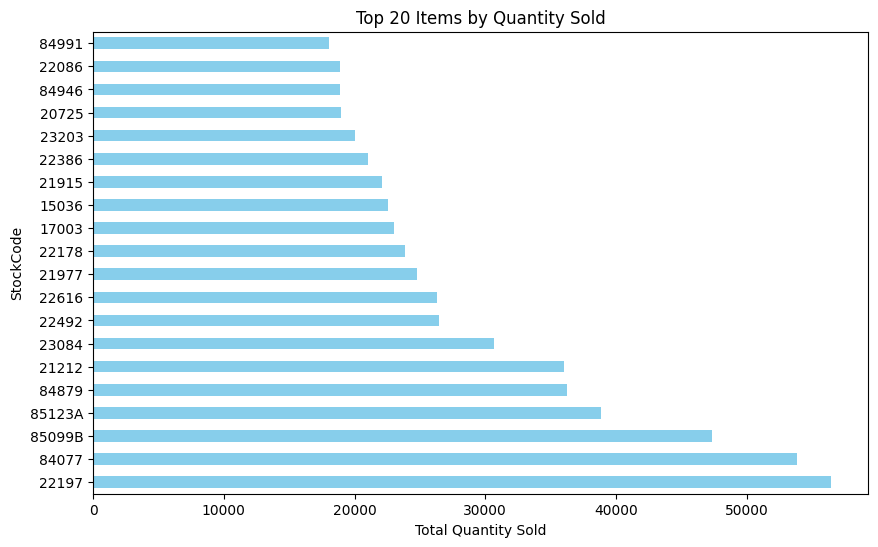

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# 3.1️⃣ Top 20 Items by Total Quantity Sold
top_items = df.groupby('StockCode')['Quantity'].sum().nlargest(20)
top_items.plot(kind='barh', figsize=(10,6), color='skyblue', title='Top 20 Items by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('StockCode')
plt.show()

In [ ]:
# 3.2️⃣ Number of Unique Customers
unique_customers = df['CustomerID'].nunique()
print(f"Number of unique customers: {unique_customers}")

Number of unique customers: 4372


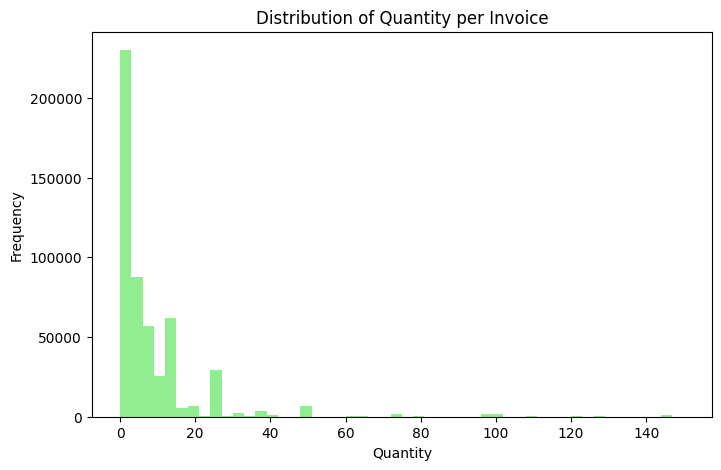

In [ ]:
# 3.3️⃣ Quantity Distribution with Rescaled X-axis
plt.figure(figsize=(8,5))
quantity = df['Quantity']
plt.hist(quantity, bins=50, range=(0, 150), color='lightgreen')
plt.title('Distribution of Quantity per Invoice')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

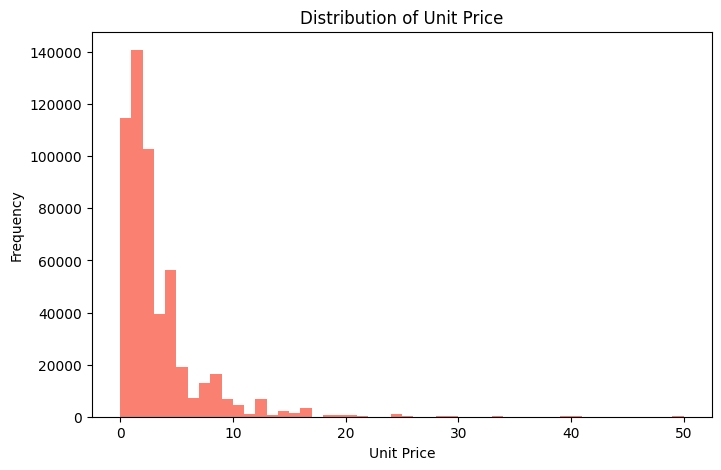

In [ ]:
# 3.4️⃣ Unit Price Distribution with Rescaled X-axis
plt.figure(figsize=(8,5))
unit_price = df['UnitPrice']
plt.hist(unit_price, bins=50, range=(0, 50), color='salmon')
plt.title('Distribution of Unit Price')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

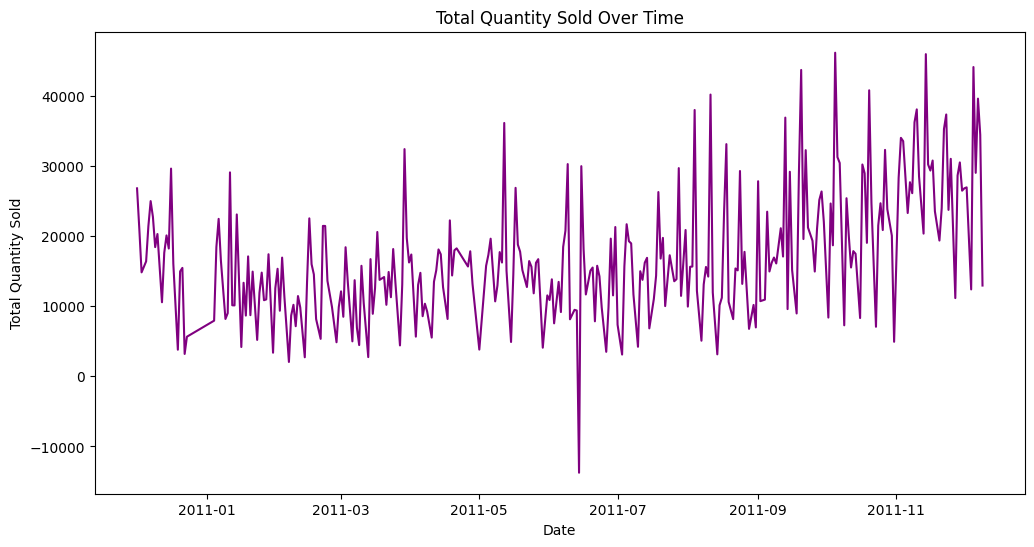

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# 3.5️⃣ Sales Over Time
sales_over_time = df.groupby(df['InvoiceDate'].dt.date)['Quantity'].sum()
sales_over_time.plot(figsize=(12,6), color='purple', title='Total Quantity Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.show()

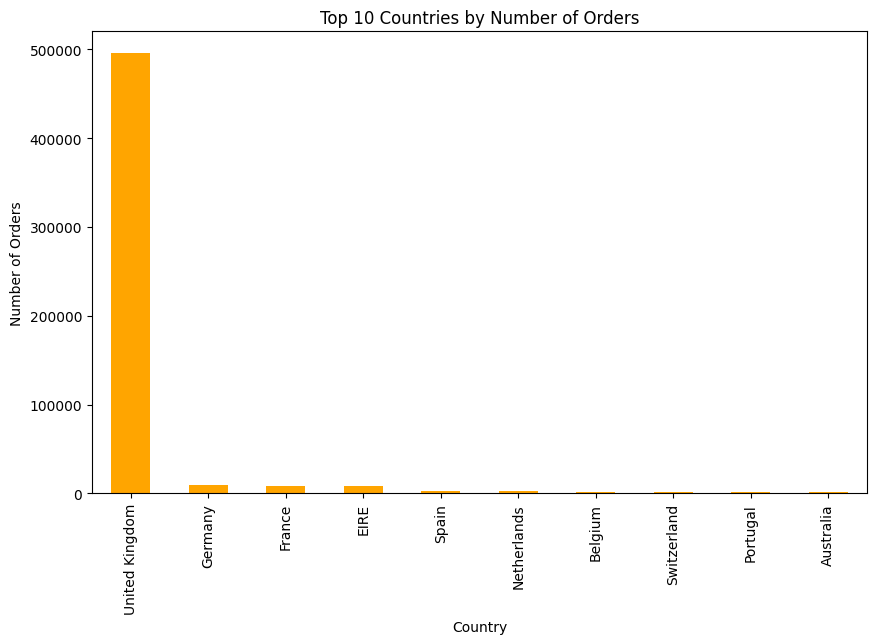

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# 3.6️⃣ Top 10 Countries by Number of Orders
top_countries = df['Country'].value_counts().nlargest(10)
top_countries.plot(kind='bar', figsize=(10,6), color='orange', title='Top 10 Countries by Number of Orders')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.show()

In [ ]:
# 3.7️⃣ Preprocessing: Filter top 20 items for RL
df_top = df[df['StockCode'].isin(top_items.index)]
df_top

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
44,536370,22492,MINI PAINT SET VINTAGE,36,2010-12-01 08:45:00,0.65,12583.0,France
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541865,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom
541871,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541874,581585,23084,RABBIT NIGHT LIGHT,12,2011-12-09 12:31:00,2.08,15804.0,United Kingdom
541875,581585,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2011-12-09 12:31:00,1.69,15804.0,United Kingdom


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


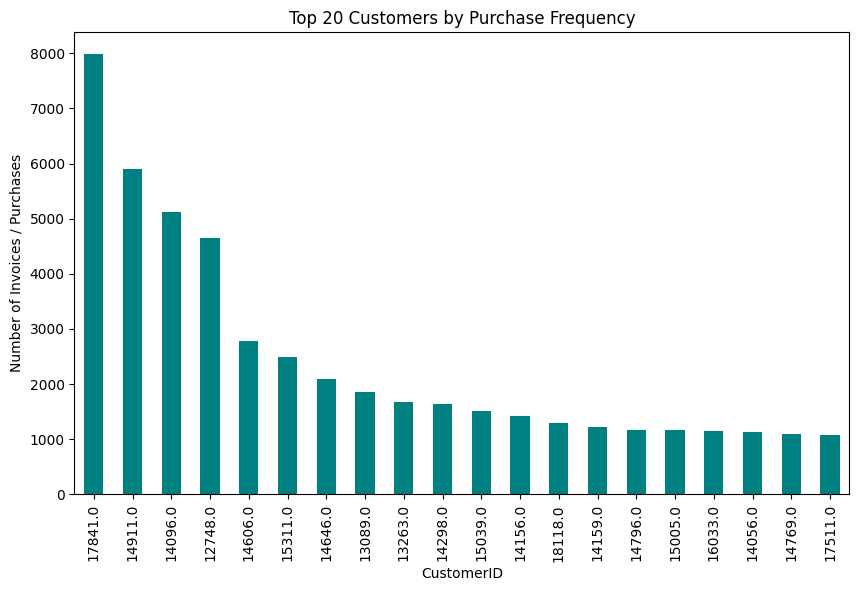

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# 3.7️⃣ Customer Frequency: How often each CustomerID buys
customer_frequency = df['CustomerID'].value_counts().nlargest(20) # top 20 customers
customer_frequency.plot(kind='bar', figsize=(10,6), color='teal', title='Top 20 Customers by Purchase Frequency')
plt.xlabel('CustomerID')
plt.ylabel('Number of Invoices / Purchases')
plt.show()

In [ ]:
# Filter for CustomerID = 17850.0
customer_id = 17850.0
df_customer = df[df['CustomerID'] == customer_id]
df_customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
86898,C543611,82483,WOOD 2 DRAWER CABINET WHITE FINISH,-1,2011-02-10 14:38:00,4.95,17850.0,United Kingdom
86899,C543611,21874,GIN AND TONIC MUG,-1,2011-02-10 14:38:00,1.06,17850.0,United Kingdom
86900,C543611,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,-2,2011-02-10 14:38:00,2.75,17850.0,United Kingdom
86901,C543611,82483,WOOD 2 DRAWER CABINET WHITE FINISH,-1,2011-02-10 14:38:00,4.95,17850.0,United Kingdom


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
Total invoices for customer 17850.0: 35
Total items purchased: 312


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


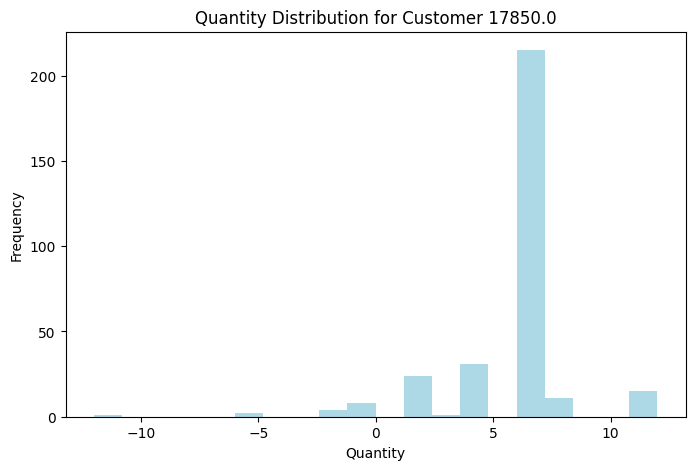

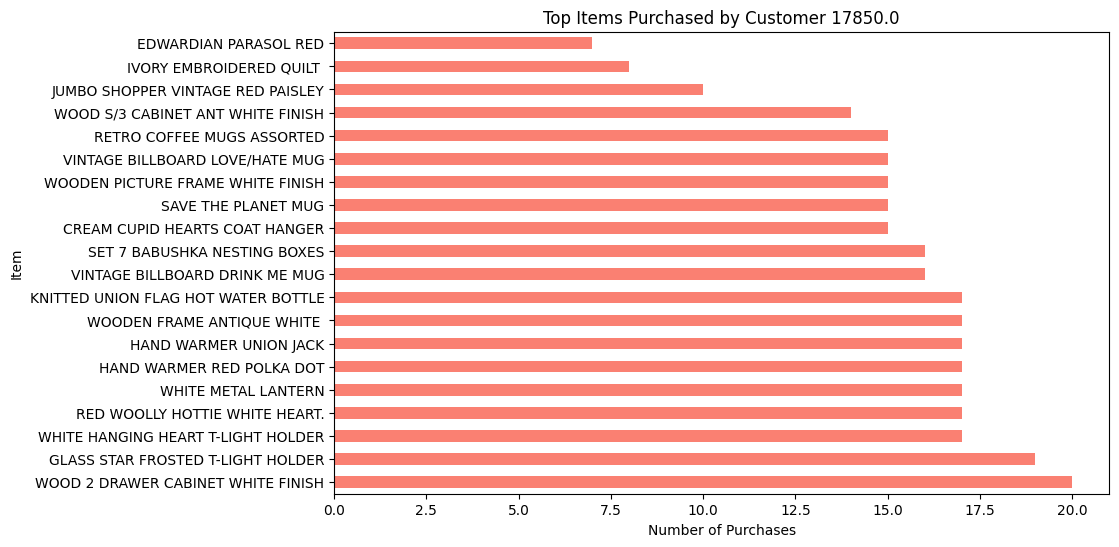

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Filter for CustomerID = 17850.0
customer_id = 17850.0
df_customer = df[df['CustomerID'] == customer_id]

# Check basic info
print(df_customer.head())
print(f"Total invoices for customer {customer_id}: {df_customer['InvoiceNo'].nunique()}")
print(f"Total items purchased: {df_customer.shape[0]}")

# 1️⃣ Quantity distribution for this customer
plt.figure(figsize=(8,5))
plt.hist(df_customer['Quantity'], bins=20, color='lightblue')
plt.title(f'Quantity Distribution for Customer {customer_id}')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

# 2️⃣ Items purchased by this customer
item_counts = df_customer['Description'].value_counts().head(20)
item_counts.plot(kind='barh', figsize=(10,6), color='salmon', title=f'Top Items Purchased by Customer {customer_id}')
plt.xlabel('Number of Purchases')
plt.ylabel('Item')
plt.show()

# 4️⃣ Define Environment

In [ ]:
class RetailEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, data):
        super().__init__()
        self.data = data
        self.customers = data['CustomerID'].dropna().unique()
        self.items = data['StockCode'].unique()
        self.n_actions = len(self.items)
        self.action_space = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Discrete(len(self.customers))
        self.current_customer_idx = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_customer_idx = 0
        return self.current_customer_idx, {}

    def step(self, action):
        customer_id = self.customers[self.current_customer_idx]
        customer_bought = self.data[self.data['CustomerID']==customer_id]['StockCode'].values
        reward = 1 if self.items[action] in customer_bought else 0
        self.current_customer_idx += 1
        done = self.current_customer_idx >= len(self.customers)
        return (self.current_customer_idx if not done else 0, reward, done, False, {})

    def render(self):
        pass

# 5️⃣ Initialize and check env

In [ ]:
env = RetailEnv(df_top)
check_env(env)

# 6️⃣ Q-Learning Agent

In [ ]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = np.zeros((n_states, n_actions))
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_actions = n_actions

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions-1)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        target = reward + self.gamma * np.max(self.q_table[next_state]) * (not done)
        self.q_table[state, action] += self.lr * (target - self.q_table[state, action])

# 7️⃣ Training Q-Learning

In [ ]:
n_states = len(env.customers)
n_actions = len(env.items)
agent = QLearningAgent(n_states, n_actions)
episodes = 5  # small for demo
q_rewards = []
for ep in range(episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    q_rewards.append(total_reward)
    print(f"Q-Learning Episode {ep+1}: Total Reward = {total_reward}")

Q-Learning Episode 1: Total Reward = 825
Q-Learning Episode 2: Total Reward = 844
Q-Learning Episode 3: Total Reward = 888
Q-Learning Episode 4: Total Reward = 911
Q-Learning Episode 5: Total Reward = 933


# 8️⃣ PPO Agent

In [ ]:
model_ppo = PPO('MlpPolicy', env, verbose=0)
model_ppo.learn(total_timesteps=5000)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# 9️⃣ A2C Agent

In [ ]:
model_a2c = A2C('MlpPolicy', env, verbose=0)
model_a2c.learn(total_timesteps=5000)

# 🔟 Dyna-Q Agent

In [ ]:
class DynaQAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=5):
        self.q_table = np.zeros((n_states, n_actions))
        self.model = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.planning_steps = planning_steps

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions-1)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        self.q_table[state, action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state]) * (not done) - self.q_table[state, action])
        self.model[(state, action)] = (reward, next_state)
        for _ in range(self.planning_steps):
            (s, a), (r, s_next) = random.choice(list(self.model.items()))
            self.q_table[s, a] += self.alpha * (r + self.gamma * np.max(self.q_table[s_next]) - self.q_table[s, a])

# 1️⃣1️⃣ Training Dyna-Q

In [ ]:
dyna_agent = DynaQAgent(n_states, n_actions)
dyna_rewards = []
for ep in range(episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dyna_agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        dyna_agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    dyna_rewards.append(total_reward)
    print(f"Dyna-Q Episode {ep+1}: Total Reward = {total_reward}")

Dyna-Q Episode 1: Total Reward = 808
Dyna-Q Episode 2: Total Reward = 792
Dyna-Q Episode 3: Total Reward = 802
Dyna-Q Episode 4: Total Reward = 838
Dyna-Q Episode 5: Total Reward = 861


# 1️⃣2️⃣ Evaluation of All Models

In [ ]:
ppo_rewards = []
obs, info = env.reset()
done = False
total_reward = 0
while not done:
    action, _states = model_ppo.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
ppo_rewards.append(total_reward)

obs, info = env.reset()
done = False
total_reward = 0
while not done:
    action, _states = model_a2c.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward

a2c_rewards = [total_reward]

# 1️⃣3️⃣ Summary Table

In [ ]:
summary = pd.DataFrame({
    'Model': ['Q-Learning', 'PPO', 'A2C', 'Dyna-Q'],
    'Average Reward': [np.mean(q_rewards), np.mean(ppo_rewards), np.mean(a2c_rewards), np.mean(dyna_rewards)],
    'Max Reward': [np.max(q_rewards), np.max(ppo_rewards), np.max(a2c_rewards), np.max(dyna_rewards)],
    'Min Reward': [np.min(q_rewards), np.min(ppo_rewards), np.min(a2c_rewards), np.min(dyna_rewards)]
})
summary = summary.sort_values(by='Average Reward', ascending=False)
summary

,Model,Average Reward,Max Reward,Min Reward
0,Q-Learning,880.2,933,825
3,Dyna-Q,820.2,861,792
2,A2C,555.0,555,555
1,PPO,461.0,461,461


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# ✅ Define a success threshold
success_threshold = 50  # you can adjust this based on your environment

summary = pd.DataFrame({
    'Model': ['Q-Learning', 'PPO', 'A2C', 'Dyna-Q'],
    'Average Reward': [np.mean(q_rewards), np.mean(ppo_rewards), np.mean(a2c_rewards), np.mean(dyna_rewards)],
    'Max Reward': [np.max(q_rewards), np.max(ppo_rewards), np.max(a2c_rewards), np.max(dyna_rewards)],
    'Min Reward': [np.min(q_rewards), np.min(ppo_rewards), np.min(a2c_rewards), np.min(dyna_rewards)],
    'Std Reward (Stability)': [np.std(q_rewards), np.std(ppo_rewards), np.std(a2c_rewards), np.std(dyna_rewards)],
    'Success Rate (%)': [
        np.mean([1 if r > success_threshold else 0 for r in q_rewards]) * 100,
        np.mean([1 if r > success_threshold else 0 for r in ppo_rewards]) * 100,
        np.mean([1 if r > success_threshold else 0 for r in a2c_rewards]) * 100,
        np.mean([1 if r > success_threshold else 0 for r in dyna_rewards]) * 100
    ],
    'Convergence (Episodes)': [
        np.argmax(np.array(q_rewards) > success_threshold),
        np.argmax(np.array(ppo_rewards) > success_threshold),
        np.argmax(np.array(a2c_rewards) > success_threshold),
        np.argmax(np.array(dyna_rewards) > success_threshold)
    ]
})

summary = summary.sort_values(by='Average Reward', ascending=False)
summary

,Model,Average Reward,Max Reward,Min Reward,Std Reward (Stability),Success Rate (%),Convergence (Episodes)
0,Q-Learning,880.2,933,825,40.385146,100.0,0
3,Dyna-Q,820.2,861,792,25.521755,100.0,0
2,A2C,555.0,555,555,0.000000,100.0,0
1,PPO,461.0,461,461,0.000000,100.0,0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# 1️⃣4️⃣ Save and Load Models

In [ ]:
model_ppo.save('ppo_retail')
model_a2c.save('a2c_retail')
# Load example
model_ppo = PPO.load('ppo_retail')

# 1️⃣5️⃣ Inference Example (Random Customer)

In [ ]:
# Pick a random customer
random_customer_idx = np.random.choice(len(env.customers))
obs = random_customer_idx

# Predict action (item index)
action, _states = model_ppo.predict(obs)

# Get StockCode from action
predicted_stockcode = env.items[action]

# Map StockCode to Description
predicted_item_name = df_top[df_top['StockCode'] == predicted_stockcode]['Description'].iloc[0]

print(f"Recommended item for random customer {env.customers[random_customer_idx]}: {predicted_item_name}")

Recommended item for random customer 18094.0: WHITE HANGING HEART T-LIGHT HOLDER
